# Read SUMMA output

In [1]:
# netcdf/numpy/xray/stats
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import xarray as xr
from scipy.stats.stats import pearsonr

# OS interaction
import sys, pickle, os

# import plotting
import seaborn as sns
import matplotlib
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap
import kgraph

# Offline Turbulence Package
import turbpy

# Customize
sns.set_style("whitegrid")
sns.set_context('paper')
%matplotlib inline

In [2]:
# --------------------------------------------------------------------------------------------------------------------
# Directory Lists
# Unix
if 'linux' in sys.platform:
    dirPre = '/home/lapok/gdrive/'
# Mac
elif 'darwin' in sys.platform:
    dirPre = '/Users/karllapo/gdrive/'

dirProj = dirPre + 'SnowHydrology/proj/ModTsfc/'
dirPrint = dirProj + 'Graphics'
dirData = dirProj + 'data'

## Functions to quickly evaluate all model output

In [3]:
def evalDiurnalTs(ax, dsDict, obs, labels, ls, lcolor):
    # Tsurf scatter plot
    hours = np.arange(0, 24)
    for ex in sorted(dsDict.keys()):
        ax.plot(hours, dsDict[ex].scalarSurfaceTemp.groupby('time.hour').mean(dim='time') - 273.15,
                label=labels[ex],
                linestyle=ls[ex],
                color=lcolor[ex])
    ax.plot(hours, obs.Tsrf.groupby('time.hour').mean(dim='time'), 'k', linewidth=3, label='Obs.')
    ax.plot([0, 23], [0, 0], color='.5')
    ax.set_xlim(0, 23)
    ax.set_ylim(-12, 0)
    ax.set_xlabel('Hour of Day')
    ax.set_ylabel('T ($C^{\circ}$)')
    ax.legend(loc='best')

In [4]:
def sortFun(s):
    if 'high' in s and 'L' in s:
        return(4)
    elif 'high' in s and 'S' in s:
        return(3)
    elif 'low' in s and 'S' in s:
        return(2)
    elif 'low' in s and 'L' in s:
        return(1)

In [5]:
def snowPresence(ds, obs):
    snowPresenceArray = (obs.SP == 1) & (ds['scalarSWE'] > 0) & (ds['scalarSurfaceTemp'] < 273.2)
    return(snowPresenceArray)

def createSnowSurfTemp(ds):
    snowTempArray = ds['scalarSurfaceTemp'].where((ds['scalarSWE'] > 0) & (ds['scalarSurfaceTemp'] < 273.2))
    return(snowTempArray)

## Forcing data

In [6]:
# ----------
# Sites and forcing data
siteNames = ['SWA', 'CDP']
siteYears = {'SWA': np.arange(2006, 2012),
             'CDP': np.arange(2002, 2010)}

d1 = {'CDP': datetime(2002, 10, 1), 'SWA': datetime(2006, 10, 1)}
d2 = {'CDP': datetime(2010, 9, 30, 22, 0, 0), 'SWA': datetime(2012, 9, 30, 23, 0, 0)}

os.chdir(dirData)
CDPforce = xr.open_dataset('CDP.ModTsfc.nc')
CDPforce = CDPforce.loc[dict(time = slice(d1['CDP'], d2['CDP']))]
CDPforce_daily = CDPforce.resample(how='mean', freq='d', dim='time')

SWAforce = xr.open_dataset('SWA.ModTsfc.nc')
SWAforce = SWAforce.loc[dict(time = slice(d1['SWA'], d2['SWA']))]
SWAforce_daily = SWAforce.resample(how='mean', freq='d', dim='time')

# ----------
# Summa modeling results for each site
os.chdir(dirData  + '/summaResults')

SWA = xr.open_dataset('SWA.summaResults.forcing.nc')
SWA = xr.concat([SWA, xr.open_dataset('SWA.summaResults.internal.nc')], 'expID')
print(SWA)

CDP = xr.open_dataset('CDP.summaResults.forcing.nc')
CDP = xr.concat([CDP, xr.open_dataset('CDP.summaResults.internal.nc')], 'expID')
print(CDP)

<xarray.Dataset>
Dimensions:                (expID: 45, time: 52608)
Coordinates:
  * time                   (time) datetime64[ns] 2006-10-01 ...
    exp                    (expID) object 'longwaveBias' 'longwaveBias' ...
    family                 (expID) object 'lowLW' 'lowLW' 'highLW' 'highLW' ...
  * expID                  (expID) object 'lowLW_L' 'lowLW_S' 'highLW_S' ...
Data variables:
    scalarRainPlusMelt     (expID, time) float64 -9.999e+03 -9.999e+03 ...
    scalarSWE              (expID, time) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    scalarSnowSublimation  (expID, time) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    scalarInfiltration     (expID, time) float64 1.784e-07 3.584e-09 0.0 0.0 ...
    scalarSurfaceRunoff    (expID, time) float64 3.338e-12 7.387e-14 0.0 0.0 ...
    scalarSurfaceTemp      (expID, time) float64 283.1 280.9 279.7 278.8 ...
    scalarSenHeatTotal     (expID, time) float64 -75.53 -20.79 -19.85 -15.34 ...
    scalarLatHeatTotal     (expID, time) float64

## Model output

In [7]:
# ----------
# Experiment names - Structure Uncertainty
experiments = ['longwaveBias', 'shortwaveBias', 'specHumidBias',
               'airTempBias', 'windBias', 'layers',
               'thermalCond', 'stability']
expMetUnc = ['longwaveBias', 'shortwaveBias', 'specHumidBias',
               'airTempBias', 'windBias']
expIntern = ['layers', 'thermalCond', 'stability']
experimentType = {'forcing': expMetUnc, 'internal': expIntern}
force = {'SWA': SWAforce, 'CDP': CDPforce}
results = {'SWA': SWA, 'CDP': CDP}

# Met uncertainty experiment IDs and values
expNames = {'longwaveBias': ['lowLW_L','lowLW_S', 'highLW_S', 'highLW_L']}
expBias = {'longwaveBias': {'lowLW_L': -25, 'lowLW_S': -10, 'highLW_S': 10, 'highLW_L': 25}}

expNames['shortwaveBias'] = ['lowSW_L','lowSW_S', 'highSW_S', 'highSW_L']
expBias['shortwaveBias'] = {'lowSW_L': -80, 'lowSW_S': -30, 'highSW_S': 30, 'highSW_L': 80}

expNames['specHumidBias'] = ['lowQS_L','lowQS_S', 'highQS_S', 'highQS_L']
expBias['specHumidBias'] = {'lowQS_L': -25,  'lowQS_S': -10, 'highQS_S': 10, 'highQS_L': 25}

expNames['airTempBias'] = ['lowTair_L','lowTair_S', 'highTair_S', 'highTair_L']
expBias['airTempBias'] = {'lowTair_L': -3, 'lowTair_S': -1.5, 'highTair_S': 1.5, 'highTair_L': 3}

expNames['windBias'] = ['lowU_L','lowU_S', 'highU_S', 'highU_L']
expBias['windBias'] = {'lowU_L': -3, 'lowU_S': -1.5, 'highU_S': 1.5, 'highU_L': 3}

metName = {'longwaveBias': 'LWRadAtm',
           'shortwaveBias': 'SWRadAtm',
           'specHumidBias': 'spechum',
           'airTempBias': 'airtemp',
           'windBias': 'windspd'}

metNameTitle = {'longwaveBias': 'Longwave Bias (Wm$^{-2}$)',
           'shortwaveBias': 'Shortwave Bias (Wm$^{-2}$)',
           'specHumidBias': 'Relative Humiditiy Bias (%)',
           'airTempBias': 'Air Temperature Bias ($^{\circ}$C)',
           'windBias': 'Wind Speed Bias (m s$^{-1}$)'}

# Layer
expNames['layers'] = ['layerThin', 'layerThick', 'jrdn1991', 'CLM_2010']

# Thermal conductivity
arrayNames = ['tyen1965', 'melr1977', 'jrdn1991', 'smnv2000']
arrayAppend = ['Mid', 'Low', 'High']
expNames['thermalCond'] = [name + '_' + append for name in arrayNames for append in arrayAppend]

# Stability
arrayAppend = ['Low', 'Mid', 'High']
arrayNames = ['standard', 'louisinv', 'mahrtexp']
expNames['stability'] = [name + '_' + append for name in arrayNames for append in arrayAppend]

internalNames = {'stability': ['standard', 'louisinv', 'mahrtexp'],
                 'layers': ['layerThin', 'layerThick', 'jrdn1991', 'CLM_2010'],
                 'thermalCond': ['tyen1965', 'melr1977', 'jrdn1991', 'smnv2000']}

# ----------
# Scalar variables to extract from output
scalar_data_vars = ['scalarRainPlusMelt', 'scalarSWE', 'scalarSnowSublimation', 
                    'scalarInfiltration', 'scalarSurfaceRunoff', 'scalarSurfaceTemp',
                    'scalarSenHeatTotal', 'scalarLatHeatTotal', 'scalarSnowDepth']

In [8]:
# snow surface temperature and snow presence
SWA['SP'] = snowPresence(SWA, SWAforce)
SWA['scalarSnowTemp'] = createSnowSurfTemp(SWA)
CDP['SP'] = snowPresence(CDP, CDPforce)
CDP['scalarSnowTemp'] = createSnowSurfTemp(CDP)

//anaconda/lib/python3.5/site-packages/xarray/core/variable.py:1143: RuntimeWarning: invalid value encountered in greater
  if not reflexive
//anaconda/lib/python3.5/site-packages/xarray/core/variable.py:1143: RuntimeWarning: invalid value encountered in less
  if not reflexive


In [9]:
def diurnalTs_Criteria(ax, ds, obs, criteria, iterVar=None, labels=None, ls='-', palette='Set1', ylims=[-25, 0]):
    # Tsurf scatter plot
    hours = np.arange(0, 24)
    ds = ds.where(criteria)
    ds_obs = obs.snowTs.where(criteria.values)
    
    with sns.color_palette(palette):
        if iterVar is None:
            iterVar = ds.expID

        ax.plot(hours, ds_obs.groupby('time.hour').mean(dim='time'), 'k', linewidth=3, label='Obs.')
        for n, e in enumerate(iterVar):
            if not labels is None:
                l = labels[n]
            else:
                l = None
            ax.plot(hours, ds.sel(expID=e).scalarSnowTemp.groupby('time.hour').mean(dim='time') - 273.15,
                    label=l, linewidth=2)
        ax.set_xlim(0, 23)
        ax.set_ylim(ylims[0], ylims[1])
        ax.set_xlabel('Hour of Day')
        ax.set_ylabel('T ($C^{\circ}$)')
        if not labels is None:
            ax.legend(loc='best')
            
def diurnalTs(ax, ds, obs, iterVar=None, labels=None, ls='-', palette='Set1', ylims=[-25, 0]):
    # Tsurf scatter plot
    hours = np.arange(0, 24)
    
    with sns.color_palette(palette):
        if iterVar is None:
            iterVar = ds.expID

        ax.plot(hours, obs.groupby('time.hour').mean(dim='time'), 'k', linewidth=3, label='Obs.')
        for n, e in enumerate(iterVar):
            if not labels is None:
                l = labels[n]
            else:
                l = None
            ax.plot(hours, ds.sel(expID=e).scalarSnowTemp.groupby('time.hour').mean(dim='time') - 273.15,
                    label=l, linewidth=2)
        ax.set_xlim(0, 23)
        ax.set_ylim(ylims[0], ylims[1])
        ax.set_xlabel('Hour of Day')
        ax.set_ylabel('T ($C^{\circ}$)')
        if not labels is None:
            ax.legend(loc='best')

//anaconda/lib/python3.5/site-packages/xarray/core/variable.py:1143: RuntimeWarning: invalid value encountered in greater
  if not reflexive
//anaconda/lib/python3.5/site-packages/xarray/core/variable.py:1143: RuntimeWarning: invalid value encountered in less
  if not reflexive


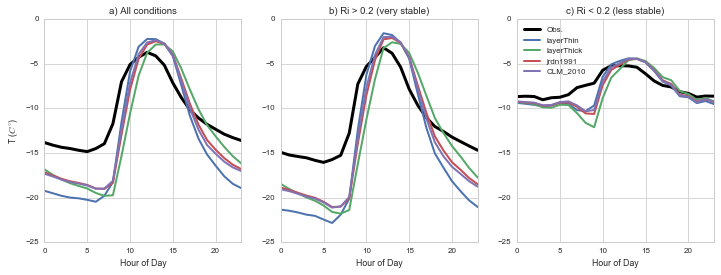

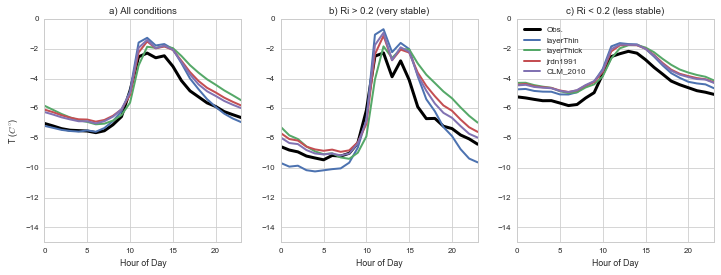

In [10]:
# --------------------------------------------------------------------------------------------------------------------
# Layers
exp = 'layers'
for s in siteNames:
    tempDS = {}
    fig, axes = plt.subplots(1, 3, figsize= (12, 4))
    axes = axes.flatten()
    if s == 'SWA':
        ylims = [-25, 0]
    if s == 'CDP':
        ylims = [-15, 0]    

    ax = axes[0]
    criteria = force[s].RiBulk > 0.
    tempDS = results[s].swap_dims({'expID': 'exp'}).sel(exp=exp)
    diurnalTs_Criteria(ax, tempDS.swap_dims({'exp': 'expID'}), force[s], criteria, ylims=ylims)
    ax.set_title('a) All conditions')

    ax = axes[1]
    criteria = force[s].RiBulk > 0.2
    diurnalTs_Criteria(ax, tempDS.swap_dims({'exp': 'expID'}), force[s], criteria, ylims=ylims)
    ax.set_ylabel('')
    ax.set_title('b) Ri > 0.2 (very stable)')

    ax = axes[2]
    criteria = force[s].RiBulk < 0.2
    diurnalTs_Criteria(ax, tempDS.swap_dims({'exp': 'expID'}), force[s], criteria,
                       labels=tempDS.expID.values, ylims=ylims)
    ax.set_ylabel('')
    ax.set_title('c) Ri < 0.2 (less stable)')

    os.chdir(dirPrint)
    fig.savefig(s + '.layers.diurnalTs.pdf', bbox_inches='tight')

//anaconda/lib/python3.5/site-packages/xarray/core/variable.py:1143: RuntimeWarning: invalid value encountered in greater
  if not reflexive
//anaconda/lib/python3.5/site-packages/xarray/core/variable.py:1143: RuntimeWarning: invalid value encountered in less
  if not reflexive


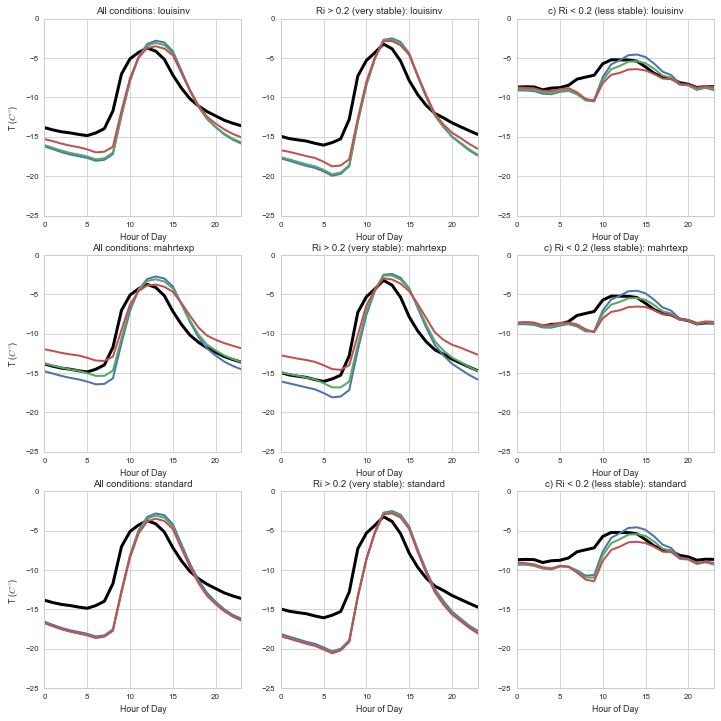

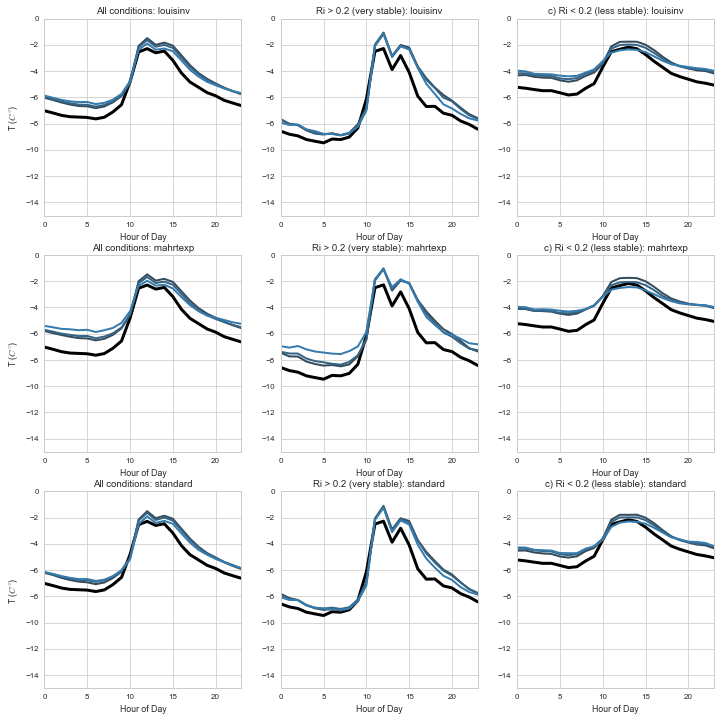

In [11]:
# -------------
# Stability
exp = 'stability'
for s in siteNames:
    tempDS = {}
    fig, axes = plt.subplots(3, 3, figsize= (12, 12))
    if s == 'SWA':
        ylims = [-25, 0]
    if s == 'CDP':
        ylims = [-15, 0]

    criteria = force[s].RiBulk > 0.
    expDataSet = results[s].swap_dims({'expID': 'exp'}).sel(exp=exp)
    pals = 'Blues_d'
    sns.set_palette(pals)
    for n, f in enumerate(np.unique(expDataSet.family.values)):
        tempDS = expDataSet.swap_dims({'exp': 'family'}).sel(family=f)
        ax = axes[n, 0]
        diurnalTs_Criteria(ax, tempDS.swap_dims({'family': 'expID'}), force[s],
                           criteria, palette=pals, ylims=ylims)
        ax.set_title('All conditions: ' + f)

    criteria = force[s].RiBulk > 0.2
    for n, f in enumerate(np.unique(expDataSet.family.values)):
        tempDS = expDataSet.swap_dims({'exp': 'family'}).sel(family=f)
        ax = axes[n, 1]
        diurnalTs_Criteria(ax, tempDS.swap_dims({'family': 'expID'}), force[s],
                           criteria, palette=pals, ylims=ylims)
        ax.set_ylabel('')
        ax.set_title('Ri > 0.2 (very stable): ' + f)

    criteria = force[s].RiBulk < 0.2
    for n, f in enumerate(np.unique(expDataSet.family.values)):
        tempDS = expDataSet.swap_dims({'exp': 'family'}).sel(family=f)
        ax = axes[n, 2]
        diurnalTs_Criteria(ax, tempDS.swap_dims({'family': 'expID'}), force[s],
                           criteria, palette=pals, ylims=ylims)
        ax.set_ylabel('')
        ax.set_title('c) Ri < 0.2 (less stable): ' + f)

    os.chdir(dirPrint)
    fig.savefig(s + '.stability.diurnalTs.pdf', bbox_inches='tight')

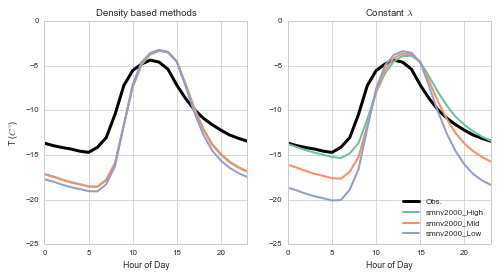

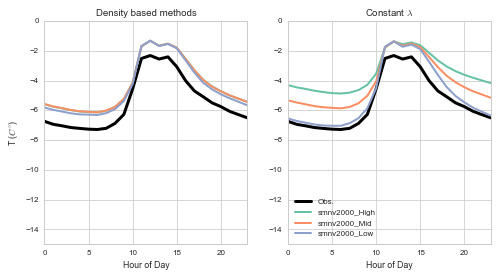

In [28]:
# -------------
# Thermal Conductivity
for s in siteNames:
    tempDS = {}
    fig, axes = plt.subplots(1, 2, figsize= (8, 4))
    if s == 'SWA':
        ylims = [-25, 0]
    if s == 'CDP':
        ylims = [-15, 0]

    # Thermal Conductivity parameterizations that are unaffected by the thermal cond param
    nonTunedThermalCond = ['melr1977_Mid', 'jrdn1991_Mid', 'tyen1965_Mid']
    tunedThermalCond = ['smnv2000_High', 'smnv2000_Mid', 'smnv2000_Low']
        
    ax = axes[0]
    criteria=force[s].SP
    diurnalTs_Criteria(ax, results[s].sel(expID=nonTunedThermalCond), force[s],
                       criteria, palette='Set1', ylims=ylims)
    ax.set_title('Density based methods')
    sns.set_palette('Set1')

    ax = axes[1]
    diurnalTs_Criteria(ax, results[s].sel(expID=tunedThermalCond), force[s],
                       criteria, palette='Set2', ylims=ylims, labels=tunedThermalCond)
    ax.set_ylabel('')
    ax.set_title('Constant $\lambda$')
    sns.set_palette('Set2')
#     os.chdir(dirPrint)
#     fig.tight_layout()
#     fig.savefig(s + '.thermalCond.diurnalTs.pdf', bbox_inches='tight')

longwaveBias


//anaconda/lib/python3.5/site-packages/xarray/core/variable.py:1143: RuntimeWarning: invalid value encountered in greater
  if not reflexive
//anaconda/lib/python3.5/site-packages/xarray/core/variable.py:1143: RuntimeWarning: invalid value encountered in less
  if not reflexive


shortwaveBias
specHumidBias
airTempBias
windBias


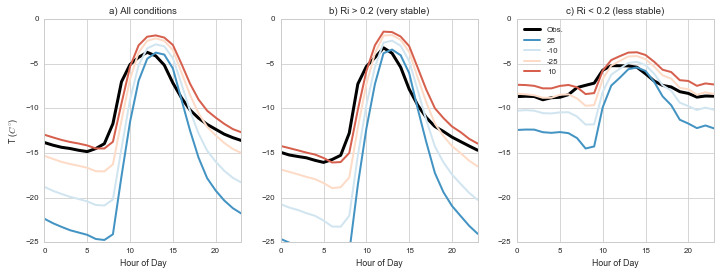

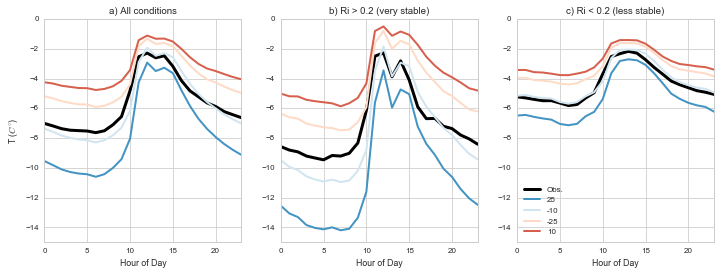

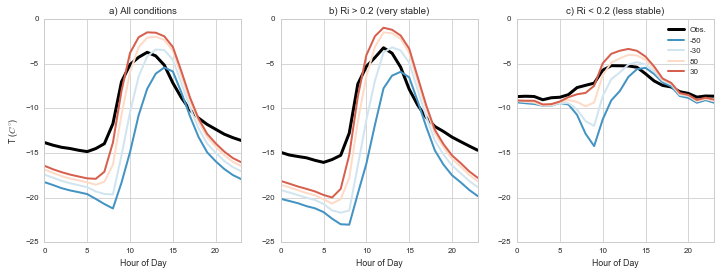

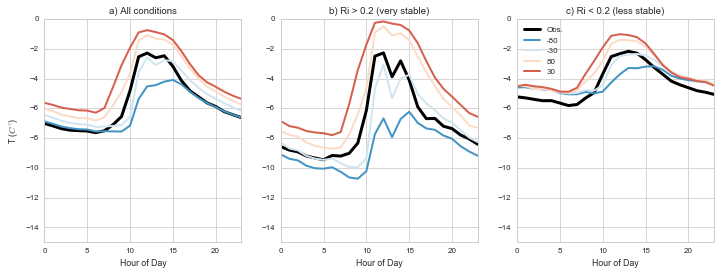

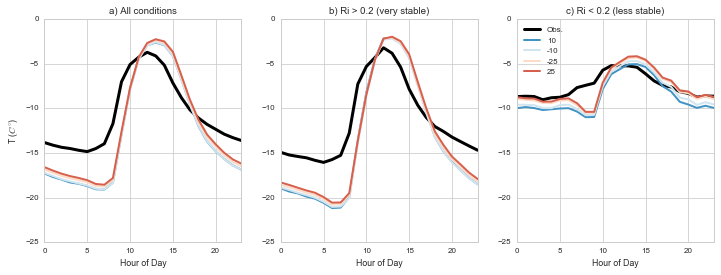

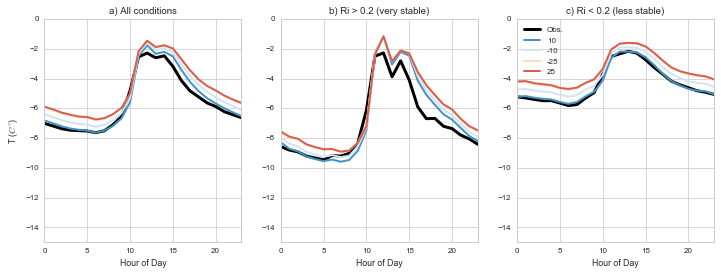

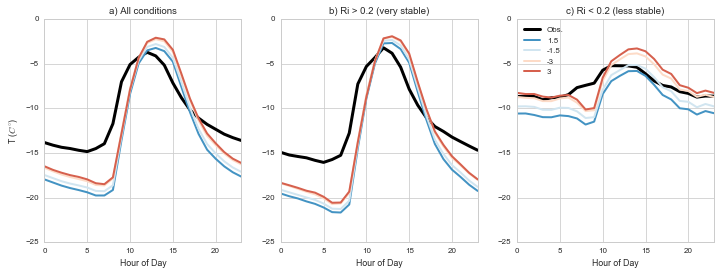

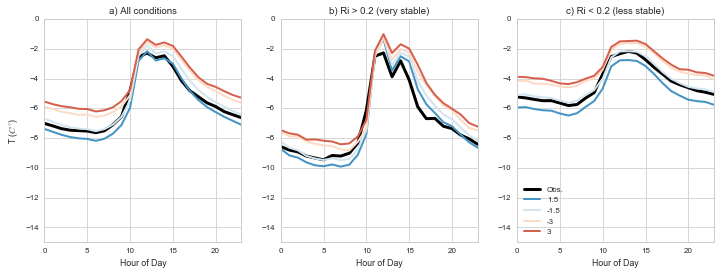

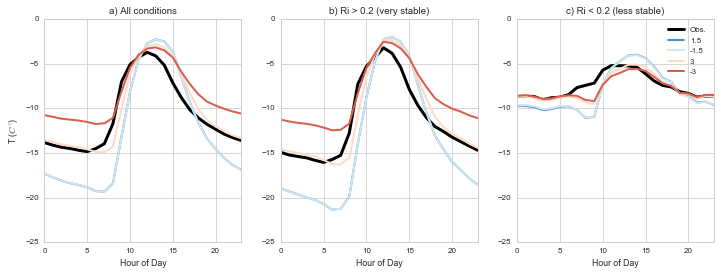

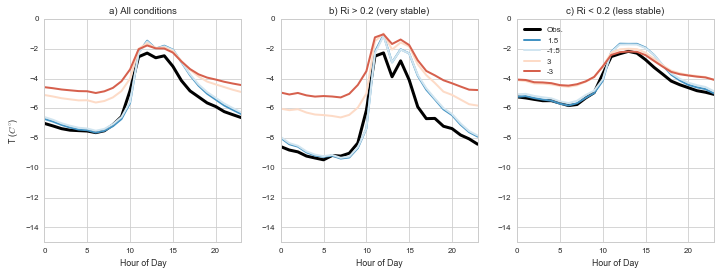

In [11]:
# -------------
# Stability
for exp in expMetUnc:
    print(exp)
    for s in siteNames:
        tempDS = {}
        fig, axes = plt.subplots(1, 3, figsize= (12, 4))
        sns.set_palette('RdBu_r', 4)
        axes = axes.flatten()
        ax = axes[0]

        # Formatting
        if s == 'SWA':
            ylims = [-25, 0]
        if s == 'CDP':
            ylims = [-15, 0]

        
        criteria = force[s].RiBulk > 0.
        tempDS = results[s].swap_dims({'expID': 'exp'}).sel(exp=exp)
        iterVar = sorted(expNames[exp], key=sortFun)

        diurnalTs_Criteria(ax, tempDS.swap_dims({'exp': 'expID'}), force[s], criteria,
                           palette=sns.color_palette('RdBu_r', 4), iterVar=iterVar, ylims=ylims)
        ax.set_title('a) All conditions')

        ax = axes[1]
        criteria = force[s].RiBulk > 0.2
        diurnalTs_Criteria(ax, tempDS.swap_dims({'exp': 'expID'}), force[s], criteria,
                           palette=sns.color_palette('RdBu_r', 4), iterVar=iterVar, ylims=ylims)
        ax.set_ylabel('')
        ax.set_title('b) Ri > 0.2 (very stable)')

        ax = axes[2]
        criteria = force[s].RiBulk < 0.2
        diurnalTs_Criteria(ax, tempDS.swap_dims({'exp': 'expID'}), force[s], criteria,
                           palette=sns.color_palette('RdBu_r', 4), iterVar=iterVar,
                           ylims=ylims, labels=list(expBias[exp].values()))
        ax.set_ylabel('')
        ax.set_title('c) Ri < 0.2 (less stable)')

        os.chdir(dirPrint)
        fig.savefig(s + '.' + exp + '.diurnalTs.pdf', bbox_inches='tight')

In [12]:
def diurnalCriteria(ax, ds, criteria, plotVar='scalarSnowTemp',
                    iterVar=None, labels=None, ls='-',
                    palette='Set1', ylims=[-25, 0]):
    # Tsurf scatter plot
    hours = np.arange(0, 24)
    ds = ds.where(criteria)
    
    with sns.color_palette(palette):
        if iterVar is None:
            iterVar = ds.expID

        for n, e in enumerate(iterVar):
            if not labels is None:
                l = labels[n]
            else:
                l = None
            if plotVar == 'scalarSnowTemp':
                ax.plot(hours, ds.sel(expID=e)[plotVar].groupby('time.hour').mean(dim='time') - 273.15,
                        label=l, linewidth=2)
            else:
                ax.plot(hours, ds.sel(expID=e)[plotVar].groupby('time.hour').mean(dim='time'),
                        label=l, linewidth=2)
        ax.set_xlim(0, 23)
        ax.set_ylim(ylims[0], ylims[1])
        ax.set_xlabel('Hour of Day')
        if not labels is None:
            ax.legend(loc='best')

## Note:
The bulk Richardson classification is probably wrong. It needs to use the specified meteorology and doesn't seem to match the bulk Richardson number calculated using observations.

longwaveBias


//anaconda/lib/python3.5/site-packages/xarray/core/variable.py:1143: RuntimeWarning: invalid value encountered in greater
  if not reflexive
//anaconda/lib/python3.5/site-packages/xarray/core/variable.py:1143: RuntimeWarning: invalid value encountered in less
  if not reflexive


shortwaveBias
specHumidBias
airTempBias
windBias


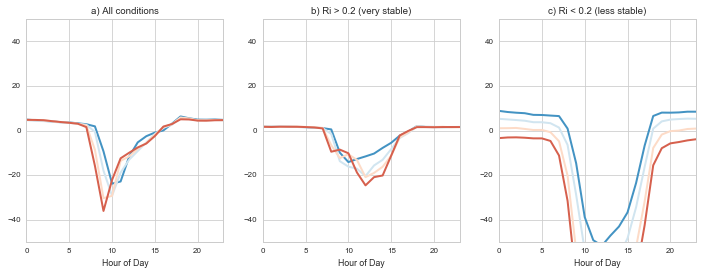

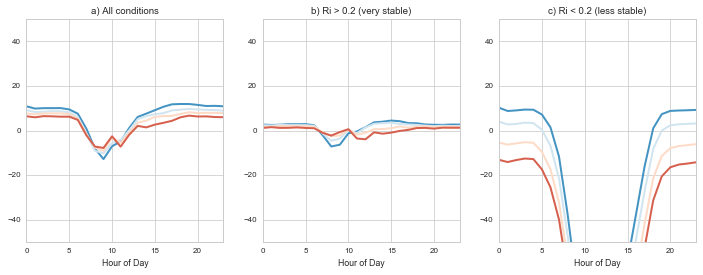

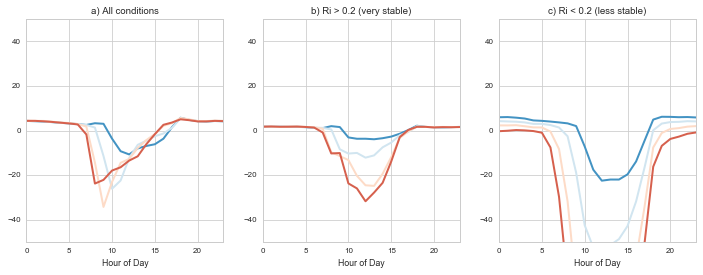

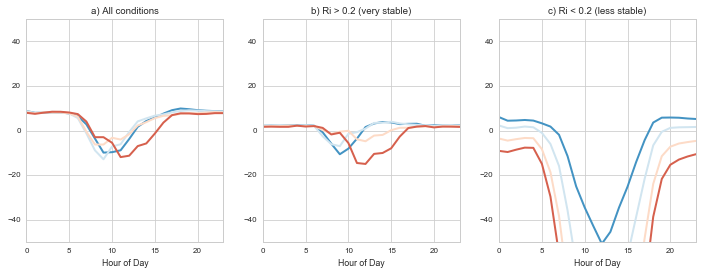

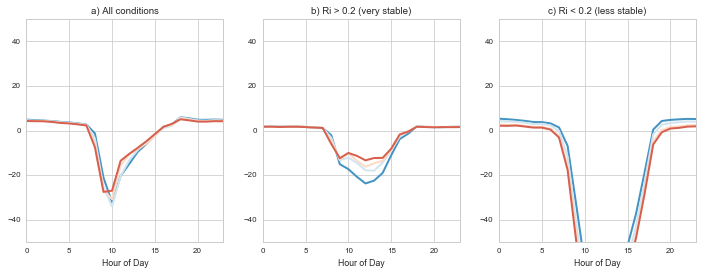

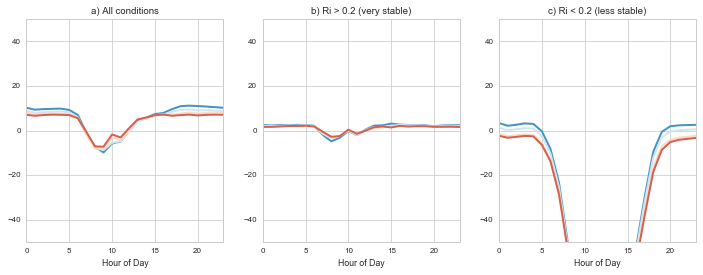

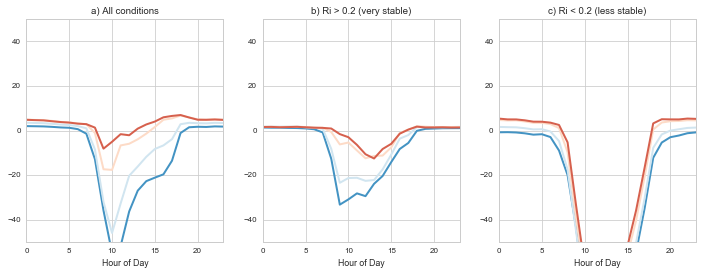

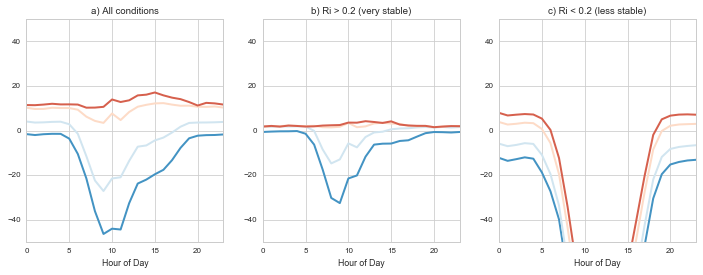

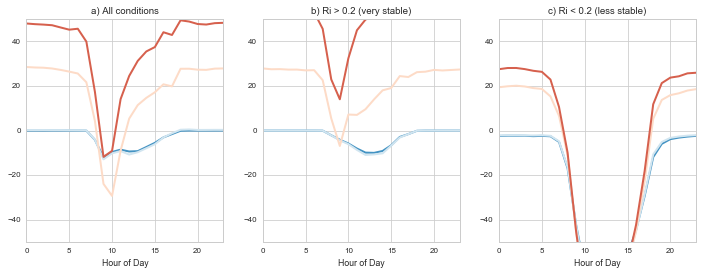

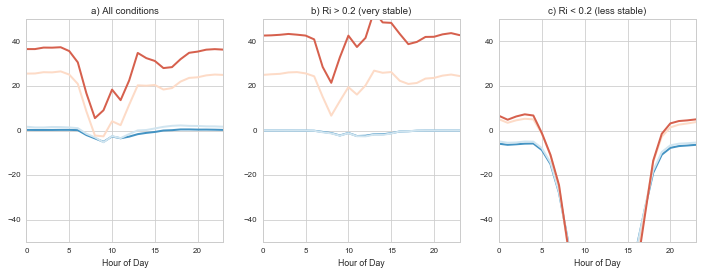

In [73]:
# -------------
# Stability
for exp in expMetUnc:
    print(exp)
    for s in siteNames:
        tempDS = {}
        fig, axes = plt.subplots(1, 3, figsize= (12, 4))
        sns.set_palette('RdBu_r', 4)
        axes = axes.flatten()
        ax = axes[0]

        # Formatting
        if s == 'SWA':
            ylims = [-50, 50]
        if s == 'CDP':
            ylims = [-50, 50]

        
        criteria = results[s].RiBulk > 0.0
        tempDS = results[s].swap_dims({'expID': 'exp'}).sel(exp=exp)
        iterVar = sorted(expNames[exp], key=sortFun)

        diurnalCriteria(ax, tempDS.swap_dims({'exp': 'expID'}), criteria, plotVar='scalarSenHeatTotal',
                        palette=sns.color_palette('RdBu_r', 4), iterVar=iterVar, ylims=ylims)
        ax.set_title('a) All conditions')

        ax = axes[1]
        criteria = results[s].RiBulk > 0.2
        diurnalCriteria(ax, tempDS.swap_dims({'exp': 'expID'}), criteria, plotVar='scalarSenHeatTotal',
                        palette=sns.color_palette('RdBu_r', 4), iterVar=iterVar, ylims=ylims)
        ax.set_ylabel('')
        ax.set_title('b) Ri > 0.2 (very stable)')

        ax = axes[2]
        criteria = results[s].RiBulk < 0.2
        diurnalCriteria(ax, tempDS.swap_dims({'exp': 'expID'}), criteria, plotVar='scalarSenHeatTotal',
                        palette=sns.color_palette('RdBu_r', 4), iterVar=iterVar, ylims=ylims)
        ax.set_ylabel('')
        ax.set_title('c) Ri < 0.2 (less stable)')

        os.chdir(dirPrint)
        fig.savefig(s + '.' + exp + '.diurnalQh.pdf', bbox_inches='tight')

longwaveBias


//anaconda/lib/python3.5/site-packages/xarray/core/variable.py:1143: RuntimeWarning: invalid value encountered in greater
  if not reflexive
//anaconda/lib/python3.5/site-packages/xarray/core/variable.py:1143: RuntimeWarning: invalid value encountered in less
  if not reflexive


shortwaveBias
specHumidBias
airTempBias
windBias


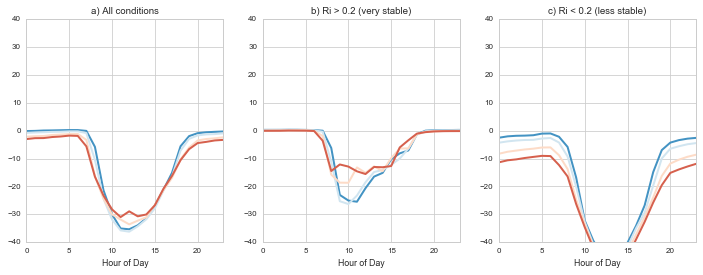

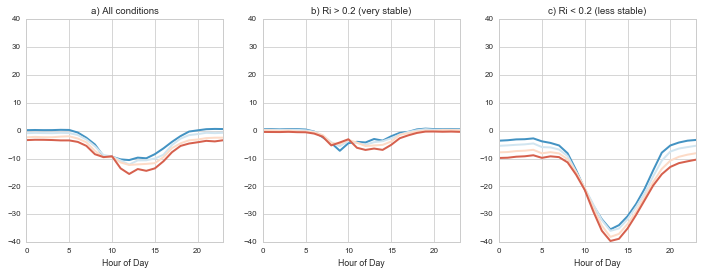

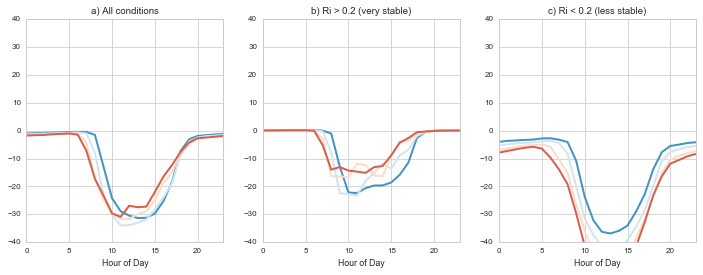

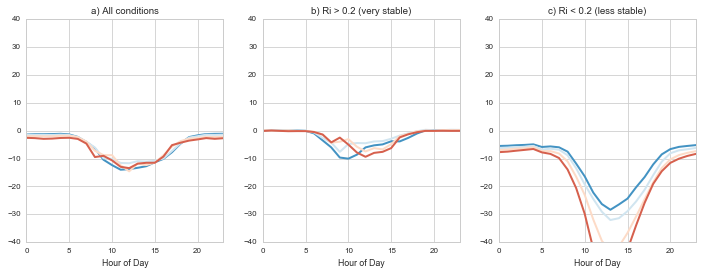

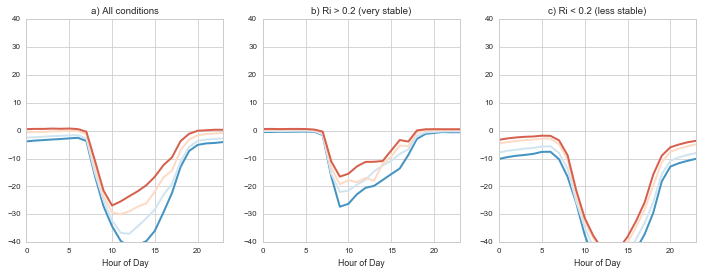

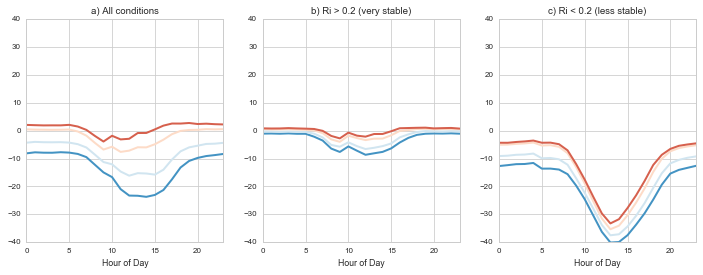

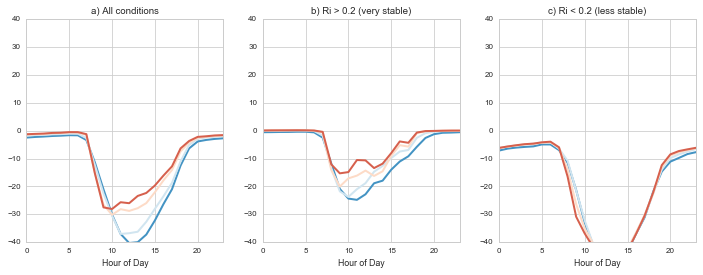

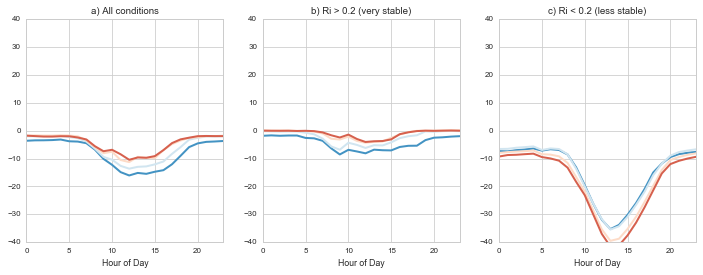

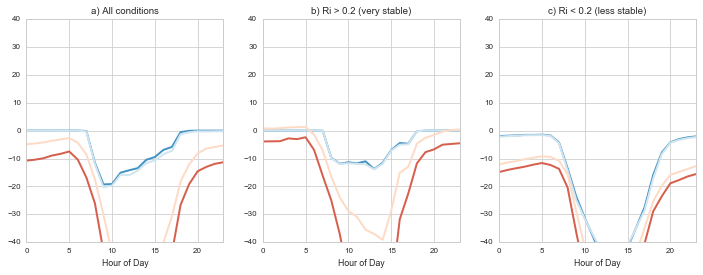

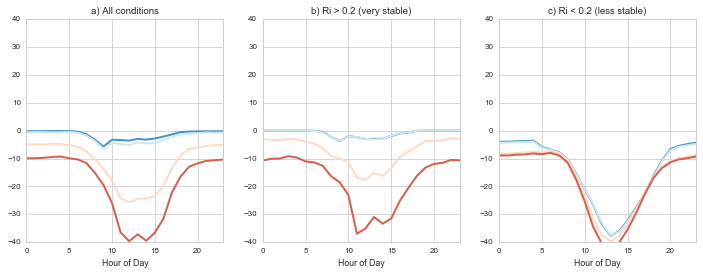

In [72]:
# -------------
# Stability
for exp in expMetUnc:
    print(exp)
    for s in siteNames:
        tempDS = {}
        fig, axes = plt.subplots(1, 3, figsize= (12, 4))
        sns.set_palette('RdBu_r', 4)
        axes = axes.flatten()
        ax = axes[0]

        # Formatting
        if s == 'SWA':
            ylims = [-40, 40]
        if s == 'CDP':
            ylims = [-40, 40]

        
        criteria = results[s].RiBulk > 0.
        tempDS = results[s].swap_dims({'expID': 'exp'}).sel(exp=exp)
        iterVar = sorted(expNames[exp], key=sortFun)

        diurnalCriteria(ax, tempDS.swap_dims({'exp': 'expID'}), criteria, plotVar='scalarLatHeatTotal',
                        palette=sns.color_palette('RdBu_r', 4), iterVar=iterVar, ylims=ylims)
        ax.set_title('a) All conditions')

        ax = axes[1]
        criteria = results[s].RiBulk > 0.2
        diurnalCriteria(ax, tempDS.swap_dims({'exp': 'expID'}), criteria, plotVar='scalarLatHeatTotal',
                        palette=sns.color_palette('RdBu_r', 4), iterVar=iterVar, ylims=ylims)
        ax.set_ylabel('')
        ax.set_title('b) Ri > 0.2 (very stable)')

        ax = axes[2]
        criteria = results[s].RiBulk < 0.2
        diurnalCriteria(ax, tempDS.swap_dims({'exp': 'expID'}), criteria, plotVar='scalarLatHeatTotal',
                        palette=sns.color_palette('RdBu_r', 4), iterVar=iterVar, ylims=ylims)
        ax.set_ylabel('')
        ax.set_title('c) Ri < 0.2 (less stable)')

        os.chdir(dirPrint)
        fig.savefig(s + '.' + exp + '.diurnalQe.pdf', bbox_inches='tight')

In [10]:
CDP['RiBulk'],_,_ = turbpy.bulkRichardson(CDPforce.Tair + 273.15, CDP.scalarSurfaceTemp,
                                          CDPforce.WIND, 3 - CDP.scalarSnowDepth)

SWA['RiBulk'],_,_ = turbpy.bulkRichardson(SWAforce.Tair + 273.15, SWA.scalarSurfaceTemp,
                                          SWAforce.WIND, 3 - SWA.scalarSnowDepth)


//anaconda/lib/python3.5/site-packages/xarray/core/variable.py:1143: RuntimeWarning: divide by zero encountered in true_divide
  if not reflexive


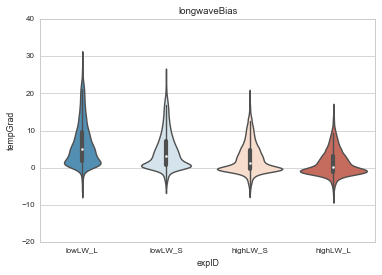

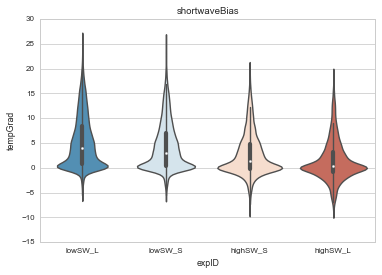

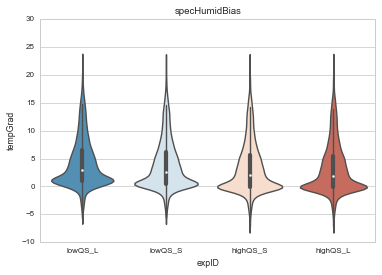

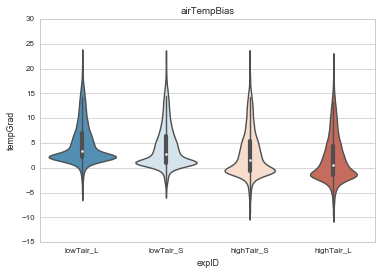

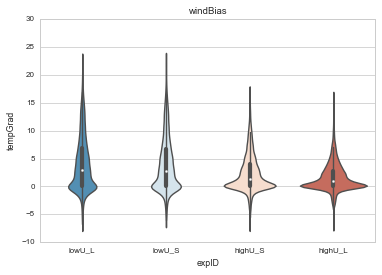

In [54]:
CDP['tempGrad'] = CDPforce.Tair - (CDP.scalarSnowTemp - 273.15)
for e in expMetUnc:
    plt.figure()
    tempGrad = CDP.swap_dims({'expID': 'exp'}).sel(exp=e).swap_dims({'exp': 'expID'})
    sns.violinplot(x='expID', y='tempGrad', data=tempGrad.to_dataframe().reset_index())
    plt.gca().set_title(e)

longwaveBias
shortwaveBias
specHumidBias
airTempBias
windBias


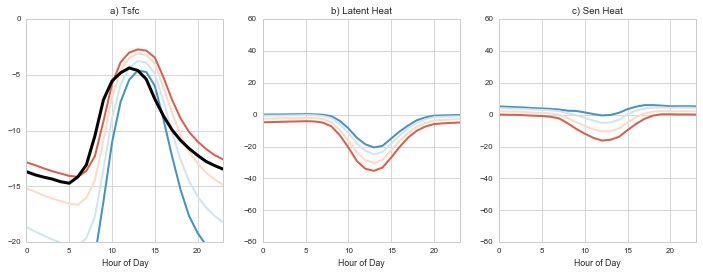

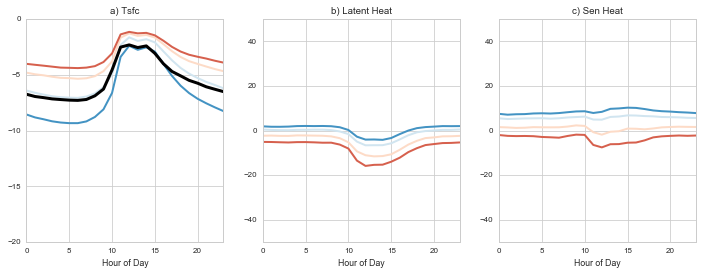

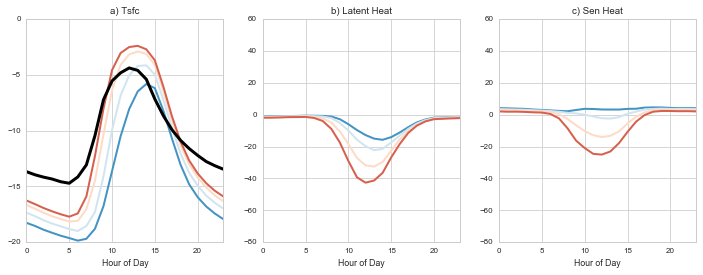

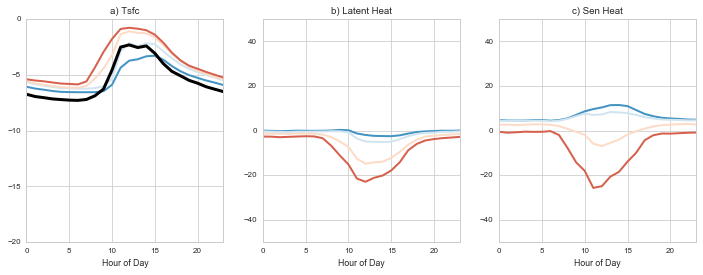

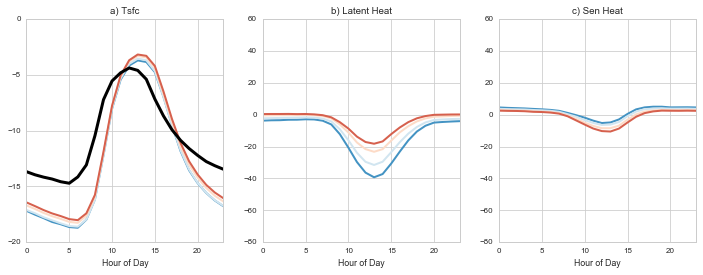

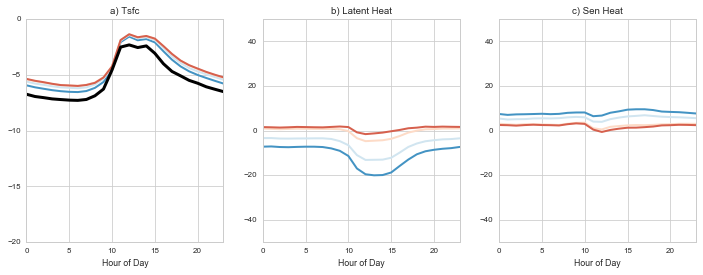

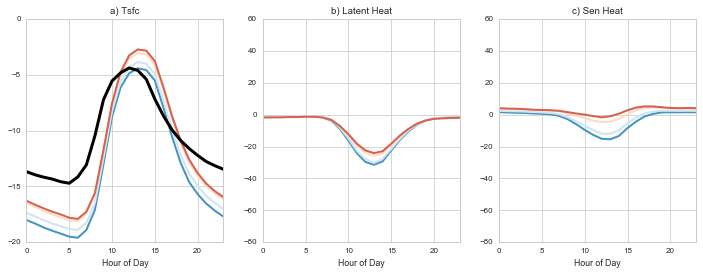

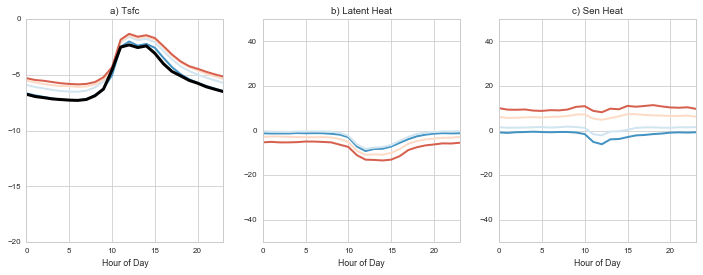

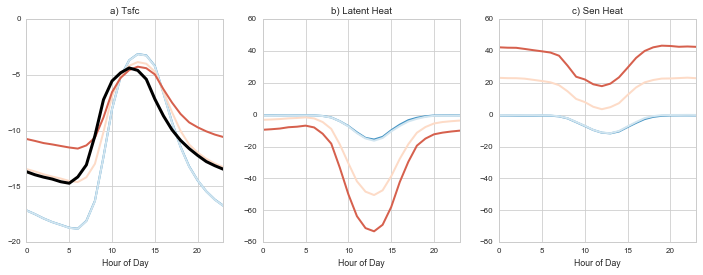

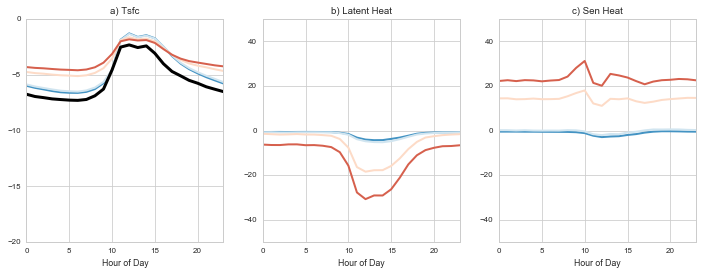

In [20]:
# -------------
# Stability
for exp in expMetUnc:
    print(exp)
    for s in siteNames:
        tempDS = {}
        # Formatting
        if s == 'SWA':
            ylims = [-80, 60]
        if s == 'CDP':
            ylims = [-50, 50]
        fig, axes = plt.subplots(1, 3, figsize= (12, 4))
        sns.set_palette('RdBu_r', 4)
        
        hours = np.arange(0, 24)
        ax = axes.flatten()[0]
        criteria = results[s].SP
        tempDS = results[s].swap_dims({'expID': 'exp'}).sel(exp=exp)
        iterVar = sorted(expNames[exp], key=sortFun)

        diurnalCriteria(ax, tempDS.swap_dims({'exp': 'expID'}), criteria, plotVar='scalarSnowTemp',
                        palette=sns.color_palette('RdBu_r', 4), iterVar=iterVar, ylims=[-20, 0])
        ax.plot(hours, force[s].snowTs.where(force[s].SP).groupby('time.hour').mean(dim='time'),
                label='Obs', linewidth=3, color='k')

        ax.set_title('a) Tsfc')
        
        ax = axes.flatten()[1]
        criteria = results[s].SP
        tempDS = results[s].swap_dims({'expID': 'exp'}).sel(exp=exp)
        iterVar = sorted(expNames[exp], key=sortFun)

        diurnalCriteria(ax, tempDS.swap_dims({'exp': 'expID'}), criteria, plotVar='scalarLatHeatTotal',
                        palette=sns.color_palette('RdBu_r', 4), iterVar=iterVar, ylims=ylims)
        ax.set_title('b) Latent Heat')
                
        ax = axes.flatten()[2]
        tempDS = results[s].swap_dims({'expID': 'exp'}).sel(exp=exp)
        iterVar = sorted(expNames[exp], key=sortFun)

        diurnalCriteria(ax, tempDS.swap_dims({'exp': 'expID'}), criteria, plotVar='scalarSenHeatTotal',
                        palette=sns.color_palette('RdBu_r', 4), iterVar=iterVar, ylims=ylims)
        ax.set_title('c) Sen Heat')

        os.chdir(dirPrint)
        fig.savefig(s + '.' + exp + '.diurnalTurbulence.pdf', bbox_inches='tight')